# FEniCS tutorial demo program 4: Poisson equation with varying diffusivity and Dirichlet boundary conditions.
## Test problem is chosen to give an exact solution at all nodes of the mesh.

## Governing Equation:

$-\nabla \cdot \kappa \nabla u = f$   

## Domain:

$([0,1] \times [0,1]) $

## Exact solution:

$u_{exact} = e^{\alpha*x*y} , \alpha=1$

## Boundary condition:

$u = u_{exact} $ on the boundary

## Forcing term:

$f = 2\alpha^2(x^2+y^2)e^{2\alpha x y}$

In [1]:
#Import modules
from __future__ import print_function
import dolfin as dl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
#Some auxillary functions defined first
def cartesian_product(array1,array2):
    #gives cartesian product of 2 vectors
    dim1,n=array1.shape
    dim2,n=array2.shape
    out_arr=np.zeros((dim1*dim2,2))
    c=0
    for a in range(dim1):
        for b in range(dim2):
            out_arr[c,:]=[array1[a],array2[b]]
            c=c+1
    return out_arr
def cartesian_product_coords(array1,array2):
    #gives cartesian product of 2 vectors
    dim1,n1=array1.shape
    dim2,n2=array2.shape
    out_arr=np.zeros((dim1*dim2,n1+n2))
    c=0
    for a in range(dim1):
        for b in range(dim2):
            #print(array1[a,:])
            #print(array2[b,:])
            out_arr[c,:]=np.append(array1[a,:],array2[b,:])
            c=c+1
    return out_arr
def cartesian_product_dofs(array1,array2):
    #gives cartesian product of 2 1d vectors
    dim1=len(array1)
    dim2=len(array2)
    out_arr=np.zeros((dim1*dim2,2))
    c=0
    for a in range(dim1):
        for b in range(dim2):
            out_arr[c,:]=[array1[a],array2[b]]
            c=c+1
    return out_arr


def cartesian_form_to_kroneck_form(indeces, len_dim_2):
    #designed to take list of indexes in the cartesian form
    #translate to single form as kron product would
    #only for cartesian product between 2 spaces
    #expects matrix with n rows, 2 columns
    num_indeces=indeces.shape[0]
    out_arr=np.zeros(num_indeces)
    for n in range(num_indeces):
        out_arr[n] = indeces[n,0]*len_dim_2 + indeces[n,1]
    return out_arr
def fetch_boundary_dofs(V1,V2,dof_coordinates1,dof_coordinates2):
    #outputs a vector of equation numbers in global system that are on the global boundary
    #input, the two function spaces of the subdomains in the cartesian product
    
    #use this to mark boundary (Dirichlet) 
    def boundary(x, on_boundary):
        return on_boundary

    #This function is simply used to mark the boundary (not the actual boundary condition)
    u_D1 = dl.Expression('1.0', degree=1)

    #establish dummy functions
    dum1=dl.Function(V1)
    dum2=dl.Function(V2)
    #get entire boundary
    bc1 = dl.DirichletBC(V1, u_D1, boundary)
    bc2 = dl.DirichletBC(V2, u_D1, boundary)

    #apply to vectors to mark boundaries
    bc1.apply(dum1.vector())
    bc2.apply(dum2.vector())

    #get index number for each boundary cooordinates in subdomain
    boundary_dofs1 = np.where(dum1.vector()==1.0)[0]
    boundary_dofs2 = np.where(dum2.vector()==1.0)[0]
  
    #coordinates of boundary in each subdomain (just for checking)
    boundary_coord1 = dof_coordinates1[boundary_dofs1]
    boundary_coord2 = dof_coordinates2[boundary_dofs2]

    #now create array of global boundary dof numbers
    global_boundary_dofs=np.empty((len(boundary_dofs1)*len(dof_coordinates2) + len(dof_coordinates1)*len(boundary_dofs2),2))

    ctr=0
    for j in boundary_dofs1:
        global_boundary_dofs[ctr*len(dof_coordinates2):(ctr+1)*len(dof_coordinates2),:] = \
        cartesian_product_dofs(np.array([j]),np.arange(dof_coordinates2.shape[0]))
        ctr=ctr+1

    last_ind = (ctr)*len(dof_coordinates2)


    for j in boundary_dofs2:
        global_boundary_dofs[last_ind:last_ind+len(dof_coordinates1),:] = \
        cartesian_product_dofs(np.arange(dof_coordinates1.shape[0]),np.array([j]))
        last_ind = last_ind+len(dof_coordinates1)    
    
    #sorts and also eliminates duplicates of "corners"
    global_boundary_dofs=np.unique(global_boundary_dofs,axis=0)

    #have cartesian product of dof at entire boundary (this form should be easy to get coordinates in if needed)
    #now need to convert to global system dof as the kron function does
    global_boundary_dofs=cartesian_form_to_kroneck_form(global_boundary_dofs, len(dof_coordinates2))
    global_boundary_dofs=global_boundary_dofs.astype(int)
    return global_boundary_dofs

In [16]:
#cartesian product of 2 1-d domains with dirichlet boundary
num_elem=32
mesh1 = dl.IntervalMesh(num_elem,0,1)
mesh2 = dl.IntervalMesh(num_elem,0,1)

#create function spaces for each piece
V1 = dl.FunctionSpace(mesh1, 'P', 1)
V2 = dl.FunctionSpace(mesh2, 'P', 1)

#create trial and test functions
u1_trial = dl.TrialFunction(V1)
v1_test = dl.TestFunction(V1)
u2_trial = dl.TrialFunction(V2)
v2_test = dl.TestFunction(V2)

#compute the global degrees of freedom
dof_coordinates1=V1.tabulate_dof_coordinates()
dof_coordinates2=V2.tabulate_dof_coordinates()
N_dof_1 = len(dof_coordinates1)
N_dof_2 = len(dof_coordinates2)
print(N_dof_1)
print(N_dof_2)

#physical coordinates should be just cartesian product of 2 dof maps in same order that kron product operates
global_dof=cartesian_product_coords(dof_coordinates1,dof_coordinates2)
#split into x,y
x = global_dof[:,0]
y = global_dof[:,1]
#calculate diffusivity at all global nodes
alpha = 1.0
kappa = np.exp(alpha*x*y)


#get dof numbers for boundary
global_boundary_dofs = fetch_boundary_dofs(V1,V2,dof_coordinates1,dof_coordinates2)

#begin to build global system
A = np.zeros((N_dof_1*N_dof_2,N_dof_1*N_dof_2))
F = np.zeros((N_dof_1*N_dof_2,N_dof_1*N_dof_2))
A1 = np.zeros((N_dof_1,N_dof_1,N_dof_2))
A2 = np.zeros((N_dof_1,N_dof_1,N_dof_2))

#get N_dof_1 x N_dof_1 functions in the domain 2
kappa_func = dl.Function(V1)

for a in range(N_dof_2):
    #have expression for kappa
    #need value at a specific dof_coordinate in second domain
    kappa_func.vector()[:] = np.array(kappa[a::N_dof_2])

    #create expressions and assemble linear forms
    K11 = kappa_func*u1_trial.dx(0)*v1_test.dx(0)*dl.dx
    K12 = kappa_func*u1_trial*v1_test*dl.dx
    
    
    #then save all matrices to list of matrices
    K11 = dl.assemble(K11)
    K12 = dl.assemble(K12)
    
    A1[:,:,a] = np.array(K11.array())
    A2[:,:,a] = np.array(K12.array())

#now use these matrices as functions to integrate and fill in each entry
#obviously looping through each entry is incredibly inefficient but is left this way for simplicity
#since this is just a small demo case. In practice, take advantage of sparsity
fy = dl.Function(V2)
for i in range(N_dof_1):
    for j in range(N_dof_1):
        fy.vector()[:] = np.array(A1[i,j,:])
        K21 = u2_trial*v2_test*fy*dl.dx
        K21 = dl.assemble(K21)
        K21 = np.array(K21.array())
        
        
        fy.vector()[:] = np.array(A2[i,j,:])
        K22 = u2_trial.dx(0)*v2_test.dx(0)*fy*dl.dx
        K22 = dl.assemble(K22)
        K22 = np.array(K22.array())
        A[i*N_dof_2:(i+1)*N_dof_2,j*N_dof_2:(j+1)*N_dof_2] = (K21 + K22)


#assemble global system using kronecker product for RHS
K11 = u1_trial*v1_test*dl.dx
K11 = dl.assemble(K11)
K11 = np.array(K11.array())
K21 = u2_trial*v2_test*dl.dx
K21 = dl.assemble(K21)
K21 = np.array(K21.array())
M = np.kron(K11,K21)

f_dof = -2*alpha**2*(x**2+y**2)*np.exp(2*alpha*x*y)
B = M.dot(f_dof)

#construct right hand side
u_true = np.exp(alpha*x*y)






#need to apply bcs using boundary_dofs info
#set the rows in the boundary to 1 on diagonal
K_bound = np.zeros(A.shape)
for i in global_boundary_dofs:
    K_bound[i,i] = 1

A[global_boundary_dofs,:] = K_bound[global_boundary_dofs,:]


#set the value of solution on boundary as rhs
B[global_boundary_dofs] = u_true[global_boundary_dofs]

#solve global system
u=np.zeros(len(B))

#solve(A,u,B)
u=np.linalg.solve(A,B)

print(u[global_boundary_dofs]-u_true[global_boundary_dofs])

33
33
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]


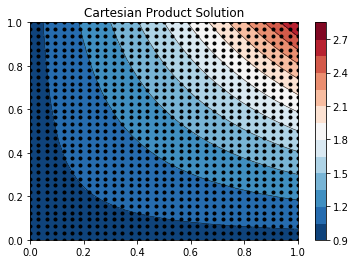

In [17]:
#now find way to plot (we know we have regular grid in this case)
fig,  ax2 = plt.subplots(nrows=1)

ax2.tricontour(global_dof[:,0], global_dof[:,1], u, levels=14, linewidths=0.5, colors='k')
cntr2 = ax2.tricontourf(global_dof[:,0], global_dof[:,1], u, levels=14, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax2)
ax2.plot(global_dof[:,0], global_dof[:,1], 'ko', ms=3)
#ax2.set(xlim=(0, 1), ylim=(0, 1))
ax2.set_title('Cartesian Product Solution')

plt.subplots_adjust(hspace=0.5)
plt.show()

#print(u)

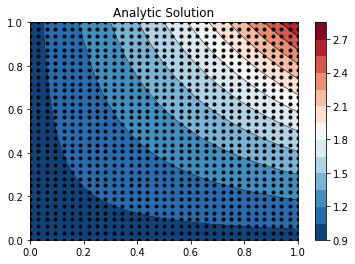

In [18]:
#plot analytic solution
#now find way to plot (we know we have regular grid in this case)
fig,  ax2 = plt.subplots(nrows=1)


ax2.tricontour(global_dof[:,0], global_dof[:,1], u_true, levels=14, linewidths=0.5, colors='k')
cntr2 = ax2.tricontourf(global_dof[:,0], global_dof[:,1], u_true, levels=14, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax2)
ax2.plot(global_dof[:,0], global_dof[:,1], 'ko', ms=3)
#ax2.set(xlim=(0, 1), ylim=(0, 1))
ax2.set_title('Analytic Solution')

plt.subplots_adjust(hspace=0.5)
plt.show()
#print(u_true)

In [19]:
print('dof')
print(len(u))
print('h')
print(1/num_elem)
print('l infinity')
print(max(np.absolute(u-u_true)))
print('l2')
print(np.dot(np.absolute(u-u_true),np.absolute(u-u_true)))
print('sum of absolute error')
print(np.sum(np.absolute(u-u_true)))
print('L2 error:')
print(np.sqrt(np.sum(np.dot(M,(u-u_true)**2))))

dof
1089
h
0.03125
l infinity
0.000104064158257
l2
3.13370704385e-06
sum of absolute error
0.0472686322083
L2 error:
5.5319623869e-05


error_max = 0.0118902301662
L2 error =  0.015893801411741768


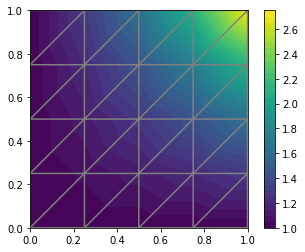

In [7]:
#non cartesian for sanity check
# Create mesh and define function space
mesh = dl.UnitSquareMesh(num_elem, num_elem)
V = dl.FunctionSpace(mesh, 'P', 1)

# Define boundary condition
u_D = dl.Expression('exp(alpha*x[0]*x[1])',alpha=alpha, degree=3,domain=mesh)


def boundary(x, on_boundary):
    return on_boundary
bc = dl.DirichletBC(V, u_D, boundary)


# Define variational problem
u = dl.TrialFunction(V)
v = dl.TestFunction(V)
f = dl.Expression('-2*alpha*alpha*(x[0]*x[0]+x[1]*x[1])*exp(2*alpha*x[0]*x[1])',alpha=alpha,degree=3)
kappa = dl.Expression('exp(alpha*x[0]*x[1])',alpha=alpha,degree=3,domain=mesh)
a = dl.dot(kappa*dl.grad(u), dl.grad(v))*dl.dx
L = f*v*dl.dx

# Compute solution
u = dl.Function(V)
dl.solve(a == L, u, bc)

# Plot solution and mesh
cm=dl.plot(u)
dl.plot(mesh)
plt.colorbar(cm)

#calculate max error
vertex_values_u_D = u_D.compute_vertex_values(mesh)
vertex_values_u = u.compute_vertex_values(mesh)
error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))

# Print errors

print('error_max =', error_max)
error_L2 = dl.errornorm(u_D, u, 'L2')
print('L2 error = ',error_L2)
# Hold plot
plt.show()
